# AWS Cost Management Adoption
## Predictive modelling and customer behavior

#### *Mark Russeff, Han Li, Andrea Hellebust, Hannah Khuong, Ying Xue, Keith Castelino*

In [1]:
# Load needed packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.decomposition import PCA 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

In [2]:
# Load files
adoption = pd.read_csv("adoption_final.csv")
april_billing = pd.read_csv("april_billing_final.csv")
may_billing = pd.read_csv("may_billing_final.csv")
june_billing = pd.read_csv("june_billing_final.csv")

## Data Preprocessing

### Dropping NA's and functions in order to clean and organize data for modelling.

In [3]:
# Drop NA
adoption = adoption.dropna()
april_billing = april_billing.dropna()
may_billing = may_billing.dropna()
june_billing = june_billing.dropna()

In [4]:
# Function for cleaning and aggregating the billing data
def clean(billing_file):
    
    # Generate the count of product_id and total expenditure for each user in April
    number_of_product_per_user = billing_file[["Customer_ID", "product_id"]].groupby("Customer_ID").count()
    total_expenditure_per_user = billing_file[["Customer_ID", "Billed_amount"]].groupby("Customer_ID").sum()
    total_expenditure_per_user = total_expenditure_per_user.astype('int')
    
    # Convert date from str to date time
    billing_file['Registration_date'] = pd.to_datetime(billing_file['Registration_date'])
    billing_file['Billing_month'] = pd.to_datetime(billing_file['Billing_month'])

    # Drop product_id and Billed_amount and remove duplicates
    billing_file = billing_file[['Billing_month', "Customer_ID", "Registration_date"]]
    billing_file = billing_file.drop_duplicates()
    
    # Calculate user age
    billing_file['User_age'] = billing_file['Billing_month'] - billing_file['Registration_date']
    
    # Convert user age to month and int type
    billing_file['User_age'] = billing_file['User_age'].dt.days
    billing_file['User_age'] = round(billing_file['User_age'] / 365, 2).astype('float')

    # Join counts of product_id and total expenditure
    billing_file = pd.merge(billing_file, number_of_product_per_user, on = 'Customer_ID', how = 'inner')
    billing_file = pd.merge(billing_file, total_expenditure_per_user, on = 'Customer_ID', how = 'inner')

    return billing_file.drop(['Billing_month', 'Registration_date'], axis = 1)

In [5]:
# Function for organizing and transposing the billing data for clustering.
# The individual distribution of customer spend is calculated and used as the main component of the cluster.
def product(billing_file):
    
    billing_file = billing_file[billing_file['Billed_amount'] >= 0]
    
    # Generate the percentage of expenditures for each product.
    total_expenditure_per_user = billing_file[["Customer_ID", "Billed_amount"]].groupby("Customer_ID").sum()
    billing_file = pd.merge(billing_file, total_expenditure_per_user, on = 'Customer_ID', how = 'inner')
    billing_file['total_expenditure_distribution'] = billing_file['Billed_amount_x'] / billing_file['Billed_amount_y'] * 100
    
    # Cut down the data set.
    billing_file = billing_file[['Customer_ID', 'product_id', 'total_expenditure_distribution']]
    
    # Transpose the data set for clustering.
    billing_file = billing_file.pivot(index= 'Customer_ID', columns='product_id', values='total_expenditure_distribution')
    
    # Replace NAN values with 0.
    billing_file = billing_file.fillna(0)
    
    return billing_file

In [6]:
# Function to standardize the data to normal distribution
def scale_product(product_file):
    
    #Get column names first
    names = product_file.columns

    #Create the Scaler object
    scaler = preprocessing.StandardScaler()

    #Fit your data on the scaler object
    product_scaled = scaler.fit_transform(product_file)
    product_scaled = pd.DataFrame(product_scaled, columns=names)
    
    return product_scaled

### Function for creating more visuallty appealling and easy to read confusion matrixes.

In [7]:
# Function that is called in order to produce a nice looking visualization for a confusion matrix
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
   
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Reds')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

### Data cleaning with output samples for quality control.

In [8]:
# Get cleaned April billing data
april_clean = clean(april_billing)

# Rename the variables
april_clean = april_clean.rename(columns = {"product_id": "April_product_amount", "Billed_amount":"April_Expenditure", "User_age":"April_user_age"})

In [9]:
april_clean.head(3)

,Customer_ID,April_user_age,April_product_amount,April_Expenditure
0,004676561936772,3.79,13,1693
1,00D351757638125,9.80,16,1442
2,00F721755330737,7.21,9,2952


In [10]:
# Get cleaned May billing data
may_clean = clean(may_billing)

# Rename the variables
may_clean = may_clean.rename(columns = {"product_id": "May_product_amount", "Billed_amount":"May_Expenditure", "User_age":"May_user_age"})

In [11]:
may_clean.head(3)

,Customer_ID,May_user_age,May_product_amount,May_Expenditure
0,004676561936772,3.87,14,1849
1,00F721755330737,7.29,9,2960
2,00R096805398488,7.25,13,5723


In [12]:
# Get cleaned June billing data
June_clean = clean(june_billing)

# Rename the variables
June_clean = June_clean.rename(columns = {"product_id": "June_product_amount", "Billed_amount":"June_Expenditure", 'User_age': 'User_Age'})
June_clean = June_clean[['Customer_ID','June_Expenditure', 'June_product_amount','User_Age']]

In [13]:
June_clean.head(3)

,Customer_ID,June_Expenditure,June_product_amount,User_Age
0,004676561936772,1619,14,3.96
1,00F721755330737,2872,9,7.38
2,00R096805398488,5462,13,7.34


In [14]:
# Combining all available data for clustering.
product_data = april_billing.append(pd.DataFrame(data = may_billing), ignore_index=True)
product_data = product_data.append(pd.DataFrame(data = june_billing), ignore_index=True)

In [15]:
# Group product data
product_data = product_data.groupby(['Customer_ID', 'product_id']).sum().reset_index()

## Clustering

In [16]:
# Get product distribution matrix
product_matrix = product(product_data)

In [17]:
# Scale the product data.
product_scaled = scale_product(product_matrix)

### Determining the optimal cluster number using the elbow method.

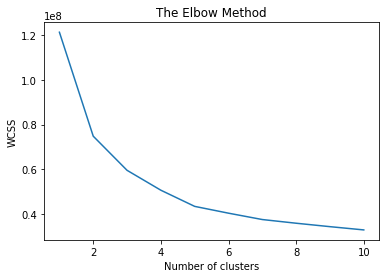

In [18]:
#Find the appropriate number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(product_matrix)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Optimal cluster was determined to be 5 clusters. K-means++ was used in order to determine the best initial centriod that would account for any outlier values.

In [19]:
#Fitting K-Means to the dataset
kmeans = KMeans(n_clusters = 5, init = 'k-means++',max_iter=300, n_init=10, random_state = 42)
y_kmeans = kmeans.fit_predict(product_matrix)

In [20]:
# Cluster numbering starting with 1 instead of 0
y_kmeans1=y_kmeans
y_kmeans1=y_kmeans+1

# New Dataframe called cluster
cluster = pd.DataFrame(y_kmeans1)

#nAdding cluster to the Product data set
product_matrix['cluster'] = cluster.iloc[:,0].values

# Mean of clusters
kmeans_mean_cluster = pd.DataFrame(round(product_matrix.groupby('cluster').mean(),4)).transpose()

### Snapshot of clustering segmentation.

In [21]:
# Lood at a snapshot of the clusters
kmeans_mean_cluster[kmeans_mean_cluster[4] >= 1]

cluster,1,2,3,4,5
product_id,,,,,
8.0,2.0492,1.7403,5.0085,4.6999,78.4103
10.0,29.6237,90.0822,14.6789,55.7236,10.6344
548.0,0.8714,0.2938,11.9920,1.4392,1.7217
938.0,56.6451,2.0525,5.6748,21.1888,2.5908
2809.0,2.4487,0.3980,3.0121,3.0922,0.2134
3991.0,2.0036,1.5374,2.2748,2.1280,1.1719
14503.0,0.7701,0.1850,3.2622,1.4654,0.1766


(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

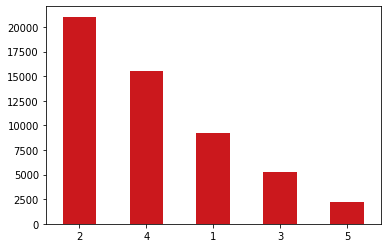

In [22]:
# Plot clusters.
pd.value_counts(product_matrix['cluster']).plot.bar(color='#cb181d')
plt.xticks(fontsize=10, rotation=360)

Examining the size and characteristics of each of the clusters we can see that they are not sized evenly and that cluster 5 is very small and is the majority of cluster 5's expenditures are focused on product 8. Cluster 2 is the largest cluster and consists of customers who allocate the majority of thier expenditures to product 10. Clusters 3 & 4 are both more balanced in terms of expenditures while cluster 1 is mostly consisted of product 10 and 938.

### Merge billing data and prepare adoption data for modelling.

In [23]:
# Prepare clusters for joining
cluster_data = product_matrix[['cluster']].reset_index()

In [24]:
# Merge dataset
April_May = pd.merge(april_clean, may_clean, on = 'Customer_ID', how = 'inner')
April_May = pd.merge(April_May, cluster_data, on = 'Customer_ID', how = 'inner')
April_May = April_May.fillna(0)
April_May['User_Age'] = April_May["May_user_age"]
April_May.loc[April_May['User_Age'] == 0,"User_Age"] = April_May["April_user_age"]
April_May = April_May.drop(['April_user_age', 'May_user_age'], axis = 1)
April_May = April_May.rename(columns = {"cluster": "Product_Cluster"})

June = pd.merge(June_clean, cluster_data, on = 'Customer_ID', how = 'inner')

In [25]:
April_May.head(3)

,Customer_ID,April_product_amount,April_Expenditure,May_product_amount,May_Expenditure,Product_Cluster,User_Age
0,004676561936772,13,1693,14,1849,2,3.87
1,00F721755330737,9,2952,9,2960,4,7.29
2,00R096805398488,13,5420,13,5723,1,7.25


In [26]:
# Replace categorical variables with nominal variables

## Customer_size: small:1, mid:2, large:3
adoption['Customer_size'] = adoption['Customer_size'].replace("Small", 1)
adoption['Customer_size'] = adoption['Customer_size'].replace("Mid", 2)
adoption['Customer_size'] = adoption['Customer_size'].replace("Large", 3)

## Geo_Code: AMER:6, EMEA:5, APAC:4, JAPN:3, CHNA:2, GLBL:1, GEO-UNCLAIMED:0
adoption['Geo_Code'] = adoption['Geo_Code'].replace("AMER", 6)
adoption['Geo_Code'] = adoption['Geo_Code'].replace("EMEA", 5)
adoption['Geo_Code'] = adoption['Geo_Code'].replace("APAC", 4)
adoption['Geo_Code'] = adoption['Geo_Code'].replace("JAPN", 3)
adoption['Geo_Code'] = adoption['Geo_Code'].replace("CHNA", 2)
adoption['Geo_Code'] = adoption['Geo_Code'].replace("GLBL", 1)
adoption['Geo_Code'] = adoption['Geo_Code'].replace("GEO-UNCLAIMED", 0)

## Visulize: Yes:1, No:0
adoption['Visualize'] = adoption['Visualize'].replace("Yes", 1)
adoption['Visualize'] = adoption['Visualize'].replace("No", 0)

## Alert: Yes:1, No:0
adoption['Alert'] = adoption['Alert'].replace("Yes", 1)
adoption['Alert'] = adoption['Alert'].replace("No", 0)

## Report: Yes:1, No:0
adoption['Report'] = adoption['Report'].replace("Yes", 1)
adoption['Report'] = adoption['Report'].replace("No", 0)

## Month: Month Only
new = adoption['Month'].str.split("-", n = 1, expand = True) 
adoption['Month'] = new[0]
adoption['Month'] = adoption['Month'].replace("April", 4)
adoption['Month'] = adoption['Month'].replace("May", 5)
adoption['Month'] = adoption['Month'].replace("June", 6)


In [27]:
adoption.head(3)

,Month,Customer_ID,Customer_size,Geo_Code,Visualize,Alert,Report
0,4,cds000000201002,1,6,1,0,0
1,5,cds000000201002,1,6,1,0,0
2,6,cds000000201002,1,6,1,0,0


### Putting together all of the data for the training and test sets.

In [28]:
# Filter for April and May adoption data
April_May_adoption = adoption[adoption['Month'] != 6]

# Create the training set.
full = pd.merge(April_May_adoption, April_May, on = 'Customer_ID', how = 'inner')

April = full[full['Month'] == 4]
April = April.drop(['May_Expenditure', 'May_product_amount'], axis = 1)
April = April.rename(columns = {"April_Expenditure": "Expenditure", 'April_product_amount': 'Product_Amount'})

May = full[full['Month'] == 4]
May = May.drop(['April_Expenditure', 'April_product_amount'], axis = 1)
May = May.rename(columns = {"May_Expenditure": "Expenditure", 'May_product_amount': 'Product_Amount'})

train = April.append(pd.DataFrame(data = May), ignore_index=True)
train = train.drop(['Customer_size'], axis = 1)


# Filter for June adoption data.
June_adoption = adoption[adoption['Month'] == 6]

# Create the validation set.
test = pd.merge(June_adoption, June, on = 'Customer_ID', how = 'inner')
test = test.drop(['Customer_size'], axis = 1)
test = test.rename(columns = {"June_Expenditure": "Expenditure", "cluster": "Product_Cluster", 'June_product_amount': 'Product_Amount'})

In [29]:
# Remove Outliers
Expenditure_thresold = train['Expenditure'].quantile(0.98)
train = train[(train['Expenditure'] <= Expenditure_thresold)]

Expenditure_thresold = test['Expenditure'].quantile(0.98)
test = test[(test['Expenditure'] <= Expenditure_thresold)]

### Looking at clusters adoption of Visualize

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

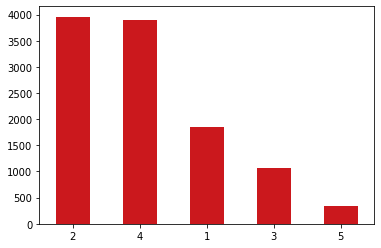

In [30]:
# Plot clusters.
testv = test[test['Visualize'] == 1]
pd.value_counts(testv['Product_Cluster']).plot.bar(color='#cb181d')
plt.xticks(fontsize=10, rotation=360)

When we look at the number of customers who use visualize based on thier segmented clusters we can see that cluster 4 has a larger percentage of Visualize adoption.

### Examining the imbalance in the data

0    63067
1    21365
Name: Visualize, dtype: int64

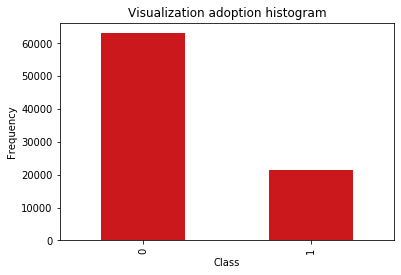

In [31]:
# Plot imbalance in data.
pd.value_counts(train['Visualize']).plot.bar(color='#cb181d')
plt.title('Visualization adoption histogram')
plt.xlabel('Class')
plt.ylabel('Frequency')
train['Visualize'].value_counts()

0    79460
1     4972
Name: Alert, dtype: int64

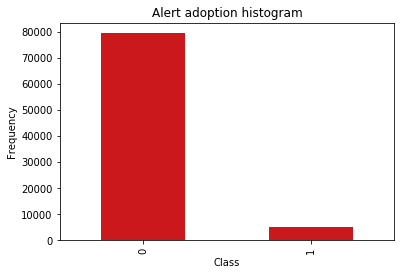

In [32]:
# Plot imbalance in data.
pd.value_counts(train['Alert']).plot.bar(color='#cb181d')
plt.title('Alert adoption histogram')
plt.xlabel('Class')
plt.ylabel('Frequency')
train['Alert'].value_counts()

0    79897
1     4535
Name: Report, dtype: int64

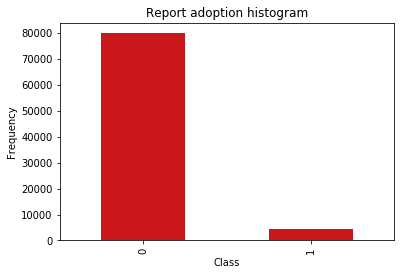

In [33]:
# Plot imbalance in data.
pd.value_counts(train['Report']).plot.bar(color='#cb181d')
plt.title('Report adoption histogram')
plt.xlabel('Class')
plt.ylabel('Frequency')
train['Report'].value_counts()

Based on the graphs we can see that the data is extremely imbalanced, particularly with Report and Alert. This is goiing to create some modelling challenges that we will have to address. The imbalanced data will make it very difficult to predict the usage of Report and Alert.

## Modelling

### Preparing the data

In [34]:
# Create the test and training sets for all three cost management variables.
y_train = train[['Visualize', 'Alert', 'Report']]
y_trainV = train[['Visualize']]
y_trainV = y_trainV.values.ravel()
y_trainA = train[['Alert']]
y_trainR = train[['Report']]

y_test = test[['Visualize', 'Alert', 'Report']]
y_testV = test[['Visualize']]
y_testV = y_testV.values.ravel()
y_testA = test[['Alert']]
y_testR = test[['Report']]

x_train = train[['User_Age', 'Geo_Code', 'Month', 'Expenditure', 'Product_Amount', 'Product_Cluster']]
x_test = test[['User_Age', 'Geo_Code', 'Month', 'Expenditure', 'Product_Amount','Product_Cluster']]

### Synthetic Minority Oversampling Technique (SMOTE) in order to address the imbalance in the data.

In [35]:
# SMOTE for Visualize target.
# Balances sample for more accurate model training.
sm = SMOTE(random_state=2)
x_train_res, y_trainV_res = sm.fit_sample(x_train, y_trainV.ravel())

Important- *Keep a keen eye out for overfitting, which can be common when using any over/under sampling technique.*

### Decision Tree Model - Visualize

In [36]:
# Decision Tree Model.
clf = tree.DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=40, max_features=None, max_leaf_nodes=None, min_samples_leaf=5, min_samples_split=2, min_weight_fraction_leaf=0.0, presort=False, random_state=100, splitter='best')
clf = clf.fit(x_train, y_trainV)

# Generate prediction.
y_pred_dt = clf.predict(x_test)

# Export as dot file for decision tree visualization.
dot_data = tree.export_graphviz(clf, out_file='Dtree_AWS.dot', feature_names = x_test.columns, max_depth =3)

In [37]:
print("Classification Report")
print(classification_report(y_testV, y_pred_dt))

Classification Report
              precision    recall  f1-score   support

           0       0.79      0.81      0.80     35066
           1       0.34      0.31      0.32     11125

    accuracy                           0.69     46191
   macro avg       0.57      0.56      0.56     46191
weighted avg       0.68      0.69      0.69     46191



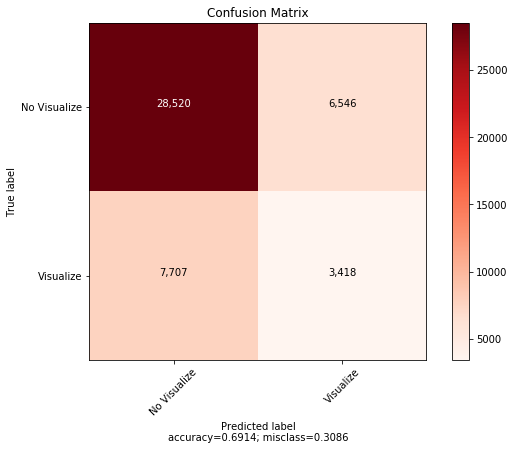

In [38]:
plot_confusion_matrix(cm           = confusion_matrix(y_testV, y_pred_dt), 
                      normalize    = False,
                      target_names = ['No Visualize', 'Visualize'],
                      title        = "Confusion Matrix")

The result of a basis decision tree is actually quite good and it gives us the dot file output so that we can create a diagram of the tree. When we look at this diagram we can make inferences about the most important features in the model. What we observe is that product number is an extremely important feature in our models, particularly when product count is high customers are more likely to use the AWS Cost Management tools.

### Neural Network Binary Choice Model - Visualize

In [39]:
# Scaler for NN.
scaler = StandardScaler()  
scaler.fit(x_train_res)

x_train_s = scaler.transform(x_train_res)  
x_test_s = scaler.transform(x_test)

In [40]:
# Predict whether customer will buy Visulization
## Multi-layer perceptron classification - one hidden layer of 5 neurons
mlp = MLPClassifier(hidden_layer_sizes=(5), random_state=100, activation= "logistic")  
mlp.fit(x_train_s, y_trainV_res)  


## predict test set 
y_pred_nn = mlp.predict(x_test_s)  

## Analysis of prediction
print("Classification Report")
print(classification_report(y_testV, y_pred_nn))

Classification Report
              precision    recall  f1-score   support

           0       0.82      0.75      0.78     35066
           1       0.38      0.49      0.43     11125

    accuracy                           0.68     46191
   macro avg       0.60      0.62      0.60     46191
weighted avg       0.71      0.68      0.70     46191



/Applications/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


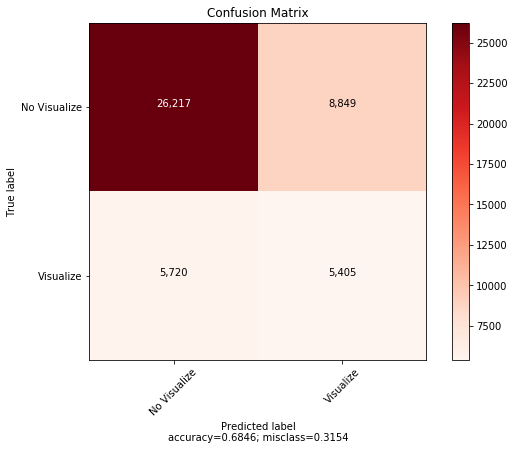

In [41]:
plot_confusion_matrix(cm           = confusion_matrix(y_testV, y_pred_nn), 
                      normalize    = False,
                      target_names = ['No Visualize', 'Visualize'],
                      title        = "Confusion Matrix")

The neural network model preformed very vell and when properly tuned was very comparable to the random forest model. The NN model was more flexible than the random forest though, it could be tuned to yield an extremely high recall but at the cost of accuracy and precision. The challenge was to find a good balance.

### Random Forest Classification - Visualize

In [42]:
# Predict whether customer will use Visualize
## Random Forest Classification
crf = RandomForestClassifier(n_estimators=20, max_depth=2, random_state=100)
crf.fit(x_train_res, y_trainV_res) 

## predict test set 
y_pred_rf = crf.predict(x_test)  

## Analysis of prediction
print("Classification Report")
print(classification_report(y_testV, y_pred_rf))

Classification Report
              precision    recall  f1-score   support

           0       0.83      0.68      0.74     35066
           1       0.35      0.56      0.43     11125

    accuracy                           0.65     46191
   macro avg       0.59      0.62      0.59     46191
weighted avg       0.71      0.65      0.67     46191



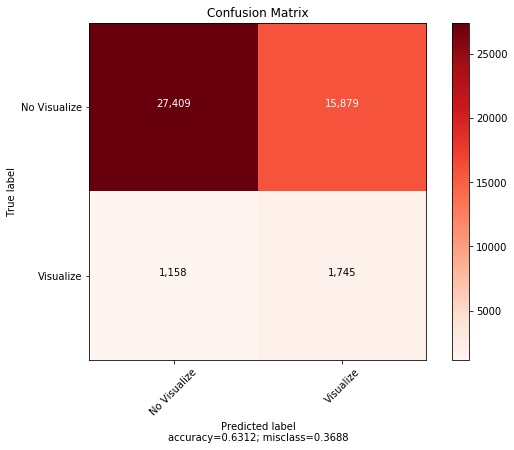

In [43]:
plot_confusion_matrix(cm           = confusion_matrix(y_testA, y_pred_rf), 
                      normalize    = False,
                      target_names = ['No Visualize', 'Visualize'],
                      title        = "Confusion Matrix")

The random forest model performed the best out of all of the model iterations that we tried. It provided good and balanced results across all of the performance measures. It is because of this that we decided to impliment a random forest model for all of our prediction models across the AWS Cost Management platform.

### Random Forest Classification - Report

In [44]:
# SMOTE for Report target.
sm = SMOTE(random_state=2)
x_train_res, y_trainR_res = sm.fit_sample(x_train, y_trainR.values.ravel())

# Predict whether customer will use Report.
## Random Forest Classification
crf = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=100)
crf.fit(x_train_res, y_trainR_res) 

## predict test set 
y_pred_rf2 = crf.predict(x_test)  

## Analysis of prediction
print("Classification Report")
print(classification_report(y_testR, y_pred_rf2))

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.80      0.87     43555
           1       0.12      0.43      0.18      2636

    accuracy                           0.78     46191
   macro avg       0.54      0.62      0.53     46191
weighted avg       0.91      0.78      0.83     46191



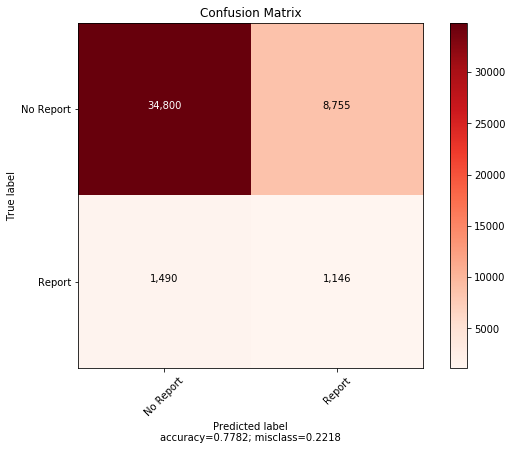

In [45]:
plot_confusion_matrix(cm           = confusion_matrix(y_testR, y_pred_rf2), 
                      normalize    = False,
                      target_names = ['No Report', 'Report'],
                      title        = "Confusion Matrix")

Unlike with Visualize the random forest model did not yield balanced results for Report; this is likely due to the dramatic imbalance in the data. While the accuracy number was very good and the recall was also quite good, the precision was terrible which made the [Yes] f1-score very low.

### Random Forest Classification - Alert

In [46]:
# SMOTE for Alert target.
sm = SMOTE(random_state=2)
x_train_res, y_trainA_res = sm.fit_sample(x_train, y_trainA.values.ravel())

# Predict Customer whether to buy Visualization
## Random Forest Classification
crf = RandomForestClassifier(n_estimators=20, max_depth=4, random_state=100)
crf.fit(x_train_res, y_trainA_res) 

## predict test set 
y_pred_rf3 = crf.predict(x_test)  

## Analysis of prediction
print("Classification Report")
print(classification_report(y_testA, y_pred_rf3))

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.78      0.86     43288
           1       0.11      0.41      0.17      2903

    accuracy                           0.76     46191
   macro avg       0.53      0.59      0.52     46191
weighted avg       0.90      0.76      0.81     46191



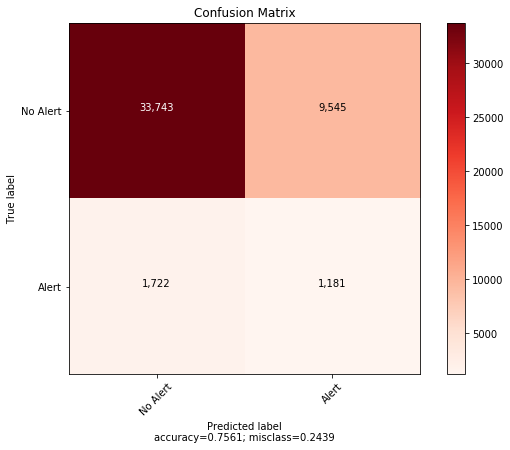

In [47]:
plot_confusion_matrix(cm           = confusion_matrix(y_testA, y_pred_rf3), 
                      normalize    = False,
                      target_names = ['No Alert', 'Alert'],
                      title        = "Confusion Matrix")

Just as with Report, Alert has very good accuracy and recall numbers but extremely low precision.

## Take-Away

The customer segmentation that was achieved by K-Means clustering showed that customers in cluster 4, those with a more diversified product mix, are more likely to use cost management and visualize in particular. This makes sound business sense as customers who use more products will have more challenges managing costs than those that use just one or two different products.

The models that we created do a fairly good job of predicting whether a customer will use an AWS Cost Management tool. However, due to the imbalance in the data, the models used to predict Alert and Report are not very sound models. It would be easy to say that because they have high accuracy and recall that they are good models but because of the data imbalance they are also not very precise at all. With that being said the Visualize model does a very good job at predicting if a customer will use AWS Visualize or not. We would be comfortable using this model in production. Additionally, when we examine the output of the decision tree for visualize we can see that the number of products a customer used is the most important feature in our models. This makes sense because customers that use a lot of products will more than likely have challenges managing the cost of those products; challenges that AWS Cost Management can help with. Based on both of these model insights we can recommend that AWS focus thier marketing on customers who are likely to use visualize. These customers are likely from the market segment in cluster 4 and use more than 17 AWS products. By focusing on customers who use an even distribution of a lot of AWS products we are confident that AWS can grow the adoption rate of their Cost Management tools.